## Testing

This notebook is designed to select the LLMs we will use for cross validation. I will consider the ten cheapest models on OpenRouter and assess their performance on the manually labelled data using the designed RAG pipeline.

In [65]:
import utils
import pandas as pd
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
import openai
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt


In [3]:
few_shot_examples = 'groundtruth_classifications.xlsx'
examples = pd.read_excel(few_shot_examples)

In [5]:
# Clean up the examples
examples = examples[examples['File name'].notna()]
examples = examples.drop(columns=['Note'])
examples['year'] = examples['File name'].str.extract(r'-(\d{2})-')
examples = examples.replace({'Yes': 1, 'No': 0})

/var/folders/br/4mkn2pts7yg8xb1_dfd6g01c0000gn/T/ipykernel_99143/2978246190.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  examples = examples.replace({'Yes': 1, 'No': 0})


In [6]:
litigation_examples = examples.drop(columns=['Climate', 'Litigation', 'General risk', 'Specific lawsuit(s)', 'File name'])
litigation_examples.rename(columns={'Paragraph': 'text', 'Company': 'company', 'Climate Litigation': 'climate_litigation'}, inplace=True)

In [7]:
litigation_examples

,company,climate_litigation,text,year
0,AIG,0,Pricing for our products is subject to our abi...,19
1,AIG,0,We are exposed to certain risks if we are unab...,19
2,AIG,0,If our businesses do not perform well and/or t...,19
3,AIG,0,We recognize that climate change has implicati...,19
4,Chevron,0,Petroleum industry operations and profitabilit...,24
...,...,...,...,...
56,United Airlines,1,"In addition, the Company believes it is possib...",24
57,Peadbody,1,The plaintiffs are the governing bodies of a v...,13
58,Conoco Philipps,1,"For example, in June 2007, the New York Office...",23
59,Conoco Philipps,1,"Beginning in 2017, governmental and other enti...",23


### Tokenizing, chunking, and embedding

In [10]:
tokenizer = AutoTokenizer.from_pretrained("nomic-ai/nomic-embed-text-v1")

In [ ]:
groundtruth_expanded = []
for _, row in litigation_examples.iterrows():
    groundtruth_expanded.extend(utils.tokenize_and_chunk(row, tokenizer))
groundtruth_df = pd.DataFrame(groundtruth_expanded)

Chunking ground truth examples...


In [27]:
groundtruth_df['climate_litigation'] = groundtruth_df['climate_litigation'].astype(int)

In [13]:
embedding_model = SentenceTransformer("nomic-ai/nomic-embed-text-v1", trust_remote_code=True)

Loading embedding model...


<All keys matched successfully>
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [14]:
gt_embeddings = utils.encode_in_batches(groundtruth_df['text'].tolist(), embedding_model, batch_size=10)

Embedding: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


In [17]:
gt_embeddings, valid_gt_idx = gt_embeddings
groundtruth_df["embedding"] = list(gt_embeddings)

### Using an LLM 

In [19]:
OPEN_ROUTER_KEY = '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'
client = openai.OpenAI(
    api_key=OPEN_ROUTER_KEY,
    base_url="https://openrouter.ai/api/v1"
)

In [ ]:
model_list = [
    "meta-llama/llama-3.2-1b-instruct", #0.005/M input tokens, $0.01/M output tokens
    "liquid/lfm-7b", #$0.01/M input tokens, $0.01/M output tokens
    "meta-llama/llama-3.2-3b-instruct", #$0.01/M input tokens, $0.02/M output
    "mistralai/mistral-nemo", #$0.01/M input tokens, $0.027/M output tokens
    "liquid/lfm-3b", #$0.02/M input tokens, $0.02/M output tokens
    "meta-llama/llama-3.1-8b-instruct", #$0.019/M input tokens, $0.03/M output tokens
    "google/gemma-3-4b-it", #$0.02/M input tokens, $0.04/M output tokens
    "sao10k/l3-lunaris-8b", #$0.02/M input tokens, $0.05/M output tokens
    "nousresearch/hermes-2-pro-llama-3-8b", #$0.025/M input tokens, $0.04/M output tokens
    "mistralai/mistral-7b-instruct", # $0.028/M input tokens, $0.054/M output tokens
]

In [ ]:
results = []

In [61]:
for model_name in model_list:
    y_true, y_pred = [], []
    skipped = []
    print(f"\n▶️ Evaluating {model_name}…")
    
    for idx, row in groundtruth_df.iterrows():
        try:
            # 1. Retrieve few-shot examples
            examples = utils.retrieve_similar_examples(
                row['text'],
                embedding_model,
                groundtruth_df,
                k=6
            )
            # 2. Get raw model response
            raw = utils.classify_with_rag(
                row['text'],
                examples,
                client,
                model_name
            )
            # 3. Try to extract an integer label
            try:
                pred = utils.extract_flag(raw)   # should return int 0 or 1
            except ValueError as e:
                skipped.append((idx, f"parse error: {e}"))
                continue
            
            # 4. Append only valid ints
            y_true.append(int(row['climate_litigation']))
            y_pred.append(pred)
            
        except Exception as err:
            # Any other error (API, retrieval, etc.)
            skipped.append((idx, str(err)))
            print(f"  ⚠️ Skipped idx={idx} due to: {err!r}")
            continue

    # 5. Compute metrics on the kept predictions
    if y_true:
        acc = accuracy_score(y_true, y_pred)
        p, r, f1, _ = precision_recall_fscore_support(
            y_true,
            y_pred,
            average="binary",
            zero_division=0
        )
    else:
        acc = p = r = f1 = 0.0

    # 6. Report & record
    print(f"✅ {model_name} — accuracy={acc:.3f}, precision={p:.3f}, recall={r:.3f}, f1={f1:.3f}")
    if skipped:
        print(f"   skipped {len(skipped)} examples (indices): {[i for i,_ in skipped]}")

    results.append({
        "model": model_name,
        "accuracy": acc,
        "precision": p,
        "recall": r,
        "f1": f1,
        "skipped_count": len(skipped),
        "skipped_indices": skipped
    })


▶️ Evaluating nousresearch/hermes-2-pro-llama-3-8b…
Tokens - Prompt: 2308, Completion: 7, Total: 2315
Tokens - Prompt: 2277, Completion: 7, Total: 2284
Tokens - Prompt: 2083, Completion: 7, Total: 2090
Tokens - Prompt: 1945, Completion: 7, Total: 1952
Tokens - Prompt: 2368, Completion: 7, Total: 2375
Tokens - Prompt: 2078, Completion: 7, Total: 2085
Tokens - Prompt: 2419, Completion: 7, Total: 2426
Tokens - Prompt: 2329, Completion: 7, Total: 2336
Tokens - Prompt: 2693, Completion: 7, Total: 2700
Tokens - Prompt: 1868, Completion: 7, Total: 1875
Tokens - Prompt: 2526, Completion: 7, Total: 2533
Tokens - Prompt: 2180, Completion: 7, Total: 2187
Tokens - Prompt: 2037, Completion: 7, Total: 2044
Tokens - Prompt: 2345, Completion: 7, Total: 2352
Tokens - Prompt: 2196, Completion: 7, Total: 2203
Tokens - Prompt: 2065, Completion: 7, Total: 2072
Tokens - Prompt: 2575, Completion: 7, Total: 2582
Tokens - Prompt: 2593, Completion: 7, Total: 2600
Tokens - Prompt: 2464, Completion: 7, Total: 24

In [62]:
results

[{'model': 'meta-llama/llama-3.2-1b-instruct',
  'accuracy': 0.7049180327868853,
  'precision': 1.0,
  'recall': 0.3793103448275862,
  'f1': 0.55,
  'skipped_count': 0,
  'skipped_indices': []},
 {'model': 'liquid/lfm-7b',
  'accuracy': 0.9016393442622951,
  'precision': 1.0,
  'recall': 0.7931034482758621,
  'f1': 0.8846153846153846,
  'skipped_count': 0,
  'skipped_indices': []},
 {'model': 'meta-llama/llama-3.2-3b-instruct',
  'accuracy': 0.9344262295081968,
  'precision': 0.9310344827586207,
  'recall': 0.9310344827586207,
  'f1': 0.9310344827586207,
  'skipped_count': 0,
  'skipped_indices': []},
 {'model': 'mistralai/mistral-nemo',
  'accuracy': 0.8688524590163934,
  'precision': 1.0,
  'recall': 0.7241379310344828,
  'f1': 0.84,
  'skipped_count': 0,
  'skipped_indices': []},
 {'model': 'liquid/lfm-3b',
  'accuracy': 0.9180327868852459,
  'precision': 0.875,
  'recall': 0.9655172413793104,
  'f1': 0.9180327868852459,
  'skipped_count': 0,
  'skipped_indices': []},
 {'model': 'me

In [91]:
metrics_df = pd.DataFrame(results)
metrics_df = metrics_df.sort_values(by='f1', ascending=False)

In [92]:
csv_path = 'model_testing_results.csv'
metrics_df.to_csv(csv_path, index=False)

In [93]:
metrics_df.drop(columns=['skipped_count', 'skipped_indices'], inplace=True)

In [94]:
price_info = {
    "meta-llama/llama-3.2-1b-instruct": {"input_price": 0.005, "output_price": 0.01},
    "liquid/lfm-7b": {"input_price": 0.01, "output_price": 0.01},
    "meta-llama/llama-3.2-3b-instruct": {"input_price": 0.01, "output_price": 0.02},
    "mistralai/mistral-nemo": {"input_price": 0.01, "output_price": 0.027},
    "liquid/lfm-3b": {"input_price": 0.02, "output_price": 0.02},
    "meta-llama/llama-3.1-8b-instruct": {"input_price": 0.019, "output_price": 0.03},
    "google/gemma-3-4b-it": {"input_price": 0.02, "output_price": 0.04},
    "sao10k/l3-lunaris-8b": {"input_price": 0.02, "output_price": 0.05},
    "nousresearch/hermes-2-pro-llama-3-8b": {"input_price": 0.025, "output_price": 0.04},
    "mistralai/mistral-7b-instruct": {"input_price": 0.028, "output_price": 0.054},
}

In [95]:
metrics_df['input_price_per_M'] = metrics_df['model'].map(lambda m: price_info[m]['input_price'])
metrics_df['output_price_per_M'] = metrics_df['model'].map(lambda m: price_info[m]['output_price'])

In [96]:
COMPANY_NUMBER = 66
RAG_CHUNKS_PER_COMPANY = 1100
APPROXIMATE_INPUT_TOKENS_PER_CHUNK = 2200
APPROXIMATE_OUTPUT_TOKENS_PER_CHUNK = 30

metrics_df['total_price'] = ((COMPANY_NUMBER * RAG_CHUNKS_PER_COMPANY*APPROXIMATE_INPUT_TOKENS_PER_CHUNK)/1_000_000 * metrics_df['input_price_per_M']) + ((COMPANY_NUMBER * RAG_CHUNKS_PER_COMPANY*APPROXIMATE_OUTPUT_TOKENS_PER_CHUNK)/1_000_000 * metrics_df['output_price_per_M'])

In [97]:
metrics_df

,model,accuracy,precision,recall,f1,input_price_per_M,output_price_per_M,total_price
7,sao10k/l3-lunaris-8b,0.967213,1.000000,0.931034,0.964286,0.020,0.050,3.303300
6,google/gemma-3-4b-it,0.950820,0.906250,1.000000,0.950820,0.020,0.040,3.281520
2,meta-llama/llama-3.2-3b-instruct,0.934426,0.931034,0.931034,0.931034,0.010,0.020,1.640760
4,liquid/lfm-3b,0.918033,0.875000,0.965517,0.918033,0.020,0.020,3.237960
5,meta-llama/llama-3.1-8b-instruct,0.918033,0.875000,0.965517,0.918033,0.019,0.030,3.100020
8,nousresearch/hermes-2-pro-llama-3-8b,0.918033,0.928571,0.896552,0.912281,0.025,0.040,4.080120
1,liquid/lfm-7b,0.901639,1.000000,0.793103,0.884615,0.010,0.010,1.618980
9,mistralai/mistral-7b-instruct,0.901639,1.000000,0.793103,0.884615,0.028,0.054,4.589772
3,mistralai/mistral-nemo,0.868852,1.000000,0.724138,0.840000,0.010,0.027,1.656006
0,meta-llama/llama-3.2-1b-instruct,0.704918,1.000000,0.379310,0.550000,0.005,0.010,0.820380


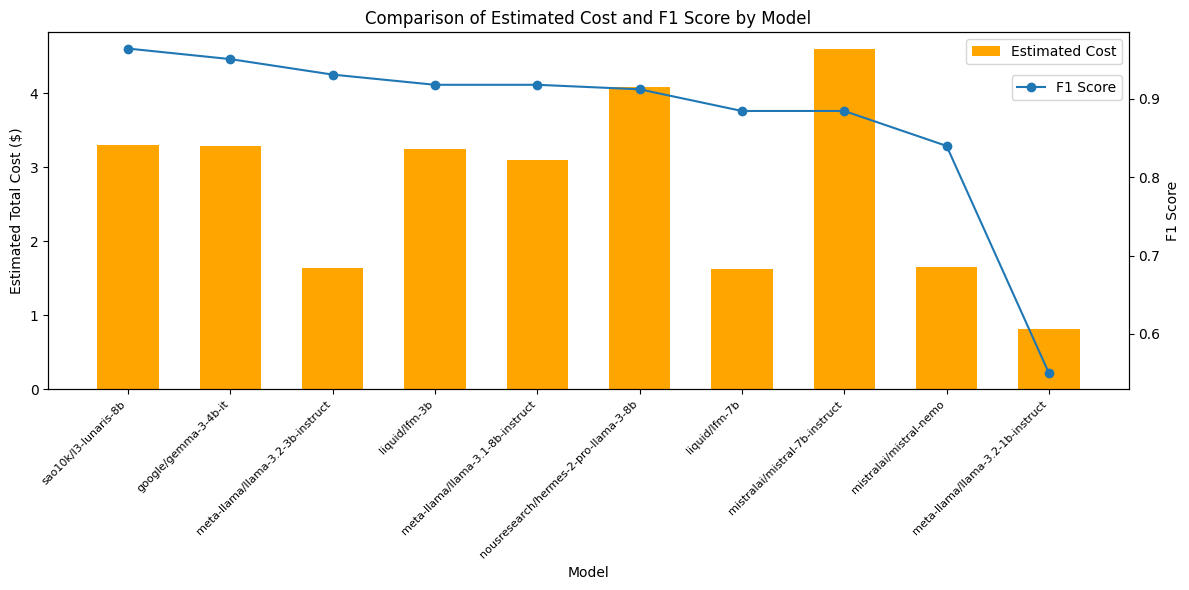

In [110]:
# Plot: cost as bars, f1 as line on twin axis
fig, ax1 = plt.subplots(figsize=(12, 6))

x = range(len(metrics_df))
models = metrics_df['model']

# Bar chart for cost
ax1.bar(x, metrics_df['total_price'], width=0.6, color='orange')
ax1.set_xlabel('Model')
ax1.set_ylabel('Estimated Total Cost ($)')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.tick_params(axis='x', labelsize=8)

# Twin axis for F1
ax2 = ax1.twinx()
ax2.plot(x, metrics_df['f1'], marker='o')
ax2.set_ylabel('F1 Score')

#add a key 
ax1.legend(['Estimated Cost'], loc='upper right')
ax2.legend(['F1 Score'], loc='upper right', bbox_to_anchor=(1, 0.9))

plt.title('Comparison of Estimated Cost and F1 Score by Model')
plt.tight_layout()
plt.show()